In [1]:
# Core functionality for managing and accessing data
from neurosynth import Dataset, decode, network
import nibabel as nib
import numpy as np
import pandas as pd
import nibabel as nib
import scipy.io
import h5py
import glob

## Inputs

In [2]:
#choose the parc
parc = 'Sch240'
# and number of nodes to extract  (in this case the whole parcellation)
n_nodes = 240
# and the mode
mode = 0

## Find rois from CCA analysis

In [3]:
# get rois of interest
docs_path = '/Users/luke/Documents/Projects/StrokeNet/Docs/'
conbound = 'conbound20/'
results_dir = docs_path + 'Results/' + conbound + parc + '/'
data = scipy.io.loadmat(results_dir + 'results.mat')
roi_list = range(n_nodes)
len(roi_list)

# get degree of CCA
modes = data['CCA'][0][0][11]
cm = modes[:, :, mode] + modes[:, :, mode].T
degree = np.sum(cm, axis=1)

## Load the parcellation

In [4]:
# get parcellation
#load the roi-parcellation
if parc=='Sch214':
    parcellation_file = '/Users/luke/Documents/Projects/StrokeNet/Docs/Atlas/Schaefer200/Schaefer200_plus_HO.nii'
elif parc=='BN':
    parcellation_file = '/Users/luke/Documents/Projects/StrokeNet/Docs/Atlas/BNAtlas/BN_Atlas_246_2mm.nii'
elif parc=='Sch240':
    parcellation_file = '/Users/luke/Documents/Projects/StrokeNet/Docs/Atlas/Schaefer200/Schaefer200_plus_HOAAL.nii'
img_parc = nib.load(parcellation_file)
img_parc_data = img_parc.get_data()

## Load the neurosynth dataset and features

In [9]:
path_to_neurosynthdata = '/Users/luke/Documents/Projects/StrokeNet/Data/topicMapping/'

# load the pickle
dataset = Dataset.load(path_to_neurosynthdata+'dataset.pkl')

# get features - https://github.com/poldrack/LatentStructure
features_df = pd.read_csv(path_to_neurosynthdata+'Poldrack_2012_terms.csv',header=None)
features_df.replace('_', ' ', regex=True,inplace=True)
cognitive_features = features_df[0].tolist()
cognitive_features = np.unique(cognitive_features)
print('number of unique terms:'+ str(np.shape(cognitive_features)))

# get features https://www.cognitiveatlas.org/
features_df = pd.read_csv(path_to_neurosynthdata+'cognitive_atlas.csv',header=None)
features_df.replace('_', ' ', regex=True,inplace=True)
cognitive_features = features_df[0].tolist()
cognitive_features = np.unique(cognitive_features)
print('number of unique terms:'+ str(np.shape(cognitive_features)))

number of unique terms:(545,)
number of unique terms:(836,)


#### Calculate number of studies
*warning! slow to load*

In [35]:
num_studies = pd.read_excel(path_to_neurosynthdata+'database.xlsx',sheet='id_only',header=0)
num_studies = num_studies['id'].values
print(len(np.unique(num_studies)),'unique studies included')

14371 unique studies included


## Save rois as Nifti

In [6]:
# for roi in roi_list:
#     roi_img = np.zeros((np.shape(img_parc_data)))
#     roi_img[img_parc_data==roi]=1
#     roi_img = nib.Nifti1Image(roi_img,img_parc.affine)
#     out_name = path_to_neurosynthdata+'roi/'+parc+'_roi_'+str(roi)+'.nii'
#     nib.save(roi_img,out_name)

## Decode the rois

### Association based decoding
Not appropriate for binary rois

### Roi based decoding
from: https://groups.google.com/forum/#!searchin/neurosynthlist/method$3D$27roi$27|sort:date/neurosynthlist/7kyLBuTXUGQ/_Xrt3pF3BQAJ

*You can select that one by passing method='roi', but be aware that it won't produce meaningful results unless you have a binary mask. Basically, it does a meta-analytic comparison of all studies that activate within the passed ROI versus all the ones that don't. If your input _is_ binary, I would probably recommend using this approach rather than the pearson approach. Otherwise stick with pearson (unless you want to implement new methods, which I would certainly welcome).*

In [36]:
## roi method
# set up the decoder
decoder = decode.Decoder(dataset,method='roi')

nii_list=[]
for nii in range(n_nodes):
    roi = roi_list[nii]
    nii = parc+'_roi_'+str(roi)
    nii_list.append(path_to_neurosynthdata+'roi/'+nii+'.nii')
    
#run the decoding
neurosynth_results = decoder.decode(nii_list, save=path_to_neurosynthdata+'decoding_results_'+parc+'_mode'+str(mode)+'.txt')
neurosynth_results.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_230,cluster_231,cluster_232,cluster_233,cluster_234,cluster_235,cluster_236,cluster_237,cluster_238,cluster_239
001,-0.9032,-2.1192,-1.8980,-2.1066,-2.6073,-1.8081,-1.5872,-1.9013,-1.5580,0.6697,...,-0.1449,-0.2998,-0.1759,-0.4664,-0.4319,0.6088,0.2972,-0.6887,-1.2984,-1.0319
01,-2.2477,-1.8384,-1.3884,-2.5304,-1.7541,-2.1688,-2.1119,-1.3074,-1.6449,-1.5339,...,-0.0801,-0.1867,-0.9322,-0.5015,-0.4073,-0.2630,-0.5914,-0.9724,-0.5748,-0.6101
05,-2.9426,-2.8533,-2.8673,-1.9915,-2.8276,-2.8395,-1.5261,-1.6372,-1.3392,-0.4081,...,-0.1228,-0.1165,-1.1874,2.3880,0.4717,-1.1572,0.7842,0.5456,-0.8509,-0.7693
10,-0.3901,-2.3408,-1.0359,-1.7362,-2.2985,-3.5007,-1.5457,-1.5665,-1.5102,1.2365,...,0.2639,0.8873,0.7523,-0.8136,0.0785,-0.9675,-0.8517,-0.5512,-1.0534,0.3063
100,-1.3477,-0.9995,0.1007,-0.1214,-0.6503,-0.7837,-0.1531,0.6097,0.0733,-0.9893,...,-0.7018,-0.2480,0.4630,-0.7775,-1.3091,-0.1174,-0.0219,-0.6609,-0.4579,-0.2229


#### trim the results to useful features

In [37]:
idx = neurosynth_results.index.isin(cognitive_features)

neurosynth_results_trimmed = neurosynth_results[idx]
neurosynth_results.to_csv(path_to_neurosynthdata+'decoding_results_'+parc+'_mode'+str(mode)+'_trimmed.txt')
print('number of trimmed features = ',np.shape(neurosynth_results_trimmed))
neurosynth_results_trimmed.head()

number of trimmed features =  (123, 240)


,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_230,cluster_231,cluster_232,cluster_233,cluster_234,cluster_235,cluster_236,cluster_237,cluster_238,cluster_239
action,-0.1215,1.7152,1.7893,-0.0425,3.3316,3.9663,3.2934,0.4431,0.2533,-0.8775,...,-1.3570,-0.0152,-0.0159,0.0151,-0.2630,-1.3516,-1.6832,-0.8031,-0.3453,-1.8059
adaptation,-3.5330,-0.2551,1.3110,-1.6736,-1.1086,0.1026,-2.1619,0.8209,-0.2780,-1.4315,...,0.3414,-0.4448,2.6064,-0.6665,0.2505,-0.1291,-0.2491,0.1358,-1.4964,-1.2181
addiction,0.0310,-1.4574,-1.8674,-0.8055,-1.8432,-0.5550,-0.4398,-1.3567,-0.8465,0.8142,...,-1.2238,-0.8760,-0.6756,0.7799,0.7129,-1.1473,-1.2014,-0.6190,-0.6104,-0.7902
anticipation,3.9638,-0.8751,-0.4119,0.1742,0.4566,-1.8261,-0.8200,-0.8752,1.5053,-0.4744,...,0.9051,0.2120,0.8045,0.9135,1.0993,2.9754,1.2089,0.8282,1.7262,-0.8677
anxiety,-0.2261,-1.8255,-0.8346,-1.2441,-1.4665,-3.0075,-2.6703,-0.8997,-1.4669,0.2167,...,1.3040,-0.0759,-0.5676,-0.2151,0.8975,-0.2242,-1.1464,-1.4252,-1.5965,-0.9326


#### normalize (zscore) and weight the features according to the CCA degree


In [39]:
#normalize
from scipy.stats import zscore
df = neurosynth_results_trimmed
for col in list(df.columns):
    df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)
degree = zscore(degree)

# threshold
df[df< 0] = 0

#multiply
df = df * degree
df = df.sum(axis=1)
print(df)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


action                     23.928022
adaptation                  0.517051
addiction                  -4.800458
anticipation              -25.040614
anxiety                   -10.542564
arousal                   -17.454474
association                -1.207229
attention                 -35.765663
autobiographical memory    16.720147
balance                    -2.373111
belief                     -9.910293
categorization            -12.318539
cognitive control         -30.499718
communication              -0.921471
competition                -0.697667
concept                     6.902397
consciousness              -2.348841
consolidation               4.430132
context                    -2.284429
coordination                5.356134
decision                  -17.357413
decision making           -18.617785
detection                  -2.663650
discrimination            -14.286788
distraction                -2.438967
eating                     -5.058895
efficiency                  2.447304
e

## Visualise the results

In [40]:
def word_brain_plot(df,nii):
    #https://github.com/amueller/word_cloud
    import matplotlib.pyplot as plt
    from nilearn import plotting
    from wordcloud import WordCloud

    def getWordFreq(df,nii):
        text = df.index.values
        freq = df[nii].values*10000
        tmpDict={}
        for i,word in enumerate(text):
            val = freq[i]
            tmpDict[word.lower()] = np.round(val)
        return tmpDict

    wc = WordCloud(background_color="white", max_words=50)
    wc.generate_from_frequencies(getWordFreq(df,nii))

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(fname, dpi=600)
    plt.show()
    
    # brain
    plotting.plot_stat_map(nii,threshold=0.1, title=nii)
    plotting.show()

def word_brain_plot_roi(df,fname):
    #https://github.com/amueller/word_cloud
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    def getWordFreq(df):
        text = df.index.values
        freq = df.values*10000
        tmpDict={}
        for i,word in enumerate(text):
            val = freq[i]
            tmpDict[word.lower()] = np.round(val)
        return tmpDict

    wc = WordCloud(background_color="white", max_words=50)
    wc.generate_from_frequencies(getWordFreq(df))

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(fname, dpi=600)
    plt.show()

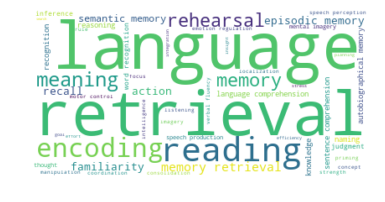

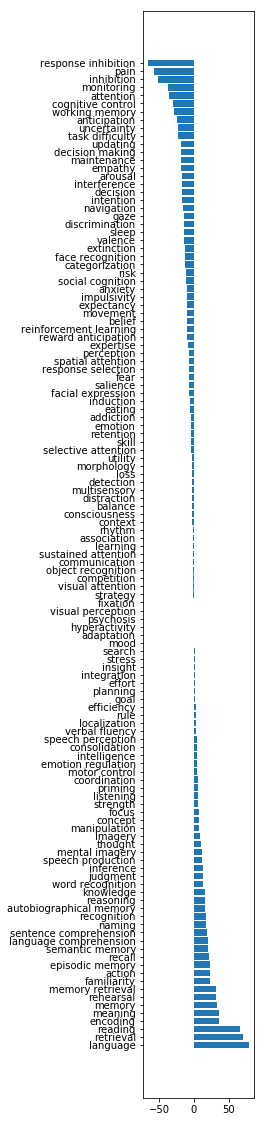

In [41]:
import matplotlib.pyplot as plt
fname = path_to_neurosynthdata+'word_clouds/decoding_results_fullbrain-weighted_'+parc+'_mode'+str(mode)+'_trimmed.jpeg'
word_brain_plot_roi(df,fname)

plt.figure(figsize=(2, 20))
values = df.values
labels = df.index.values
#plt.barh(range(len(values)),values,tick_label=labels)
#plt.show()

idx = np.argsort(values)[::-1]
values_sort = values[idx]
labels_sort = labels[idx]
plt.barh(range(len(values)),values_sort,tick_label=labels_sort)
plt.show()

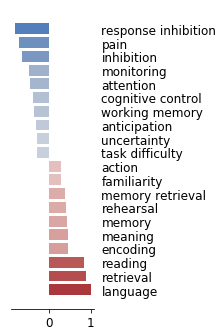

In [43]:
import seaborn as sns
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)

    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')

    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
plt.rcParams.update({'font.size': 12})
f = plt.figure(figsize=(1.5,5.5))
plt.rcParams.update({'font.family':'sans-serif','font.sans-serif':'Helvetica'})
num = 10

ax = f.add_subplot(111)
ax.yaxis.tick_right()

x = np.hstack((values_sort[0:num],values_sort[-num::]))
x = x/np.max(x)
new_labels = np.hstack((labels_sort[0:num],labels_sort[-num::]))
y_pos = np.arange(len(x))
colors = sns.cm.vlag((x + 1) / 2)

plt.barh(y_pos, x, align='center', color=colors, ecolor=colors,tick_label=new_labels)
remove_border(left=None)
plt.savefig(results_dir+'Decoding_barplot.svg',dpi=600)
plt.show()